# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2023
***

In [1]:
# Load my project packages
from utils_2d import *
keras.backend.clear_session()

2024-03-15 12:32:34.839010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 12:32:34.839068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 12:32:34.879456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 12:32:34.957739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 12:32:35.867207: W tensorflow/compiler/tf2

In [2]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.15.0
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [3]:
### Load individual datasets from simulations
timestamps, poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut = load_initial_data()

Perm: (1000, 128, 128) | Poro: (1000, 128, 128) | Channels: (1000, 128, 128) | Pressure: (1000, 45, 128, 128) | Saturation: (1000, 45, 128, 128)
OPR: (1000, 45, 3) | WPR: (1000, 45, 3) | WCUT: (1000, 45, 3) | Timestamps: (45,)


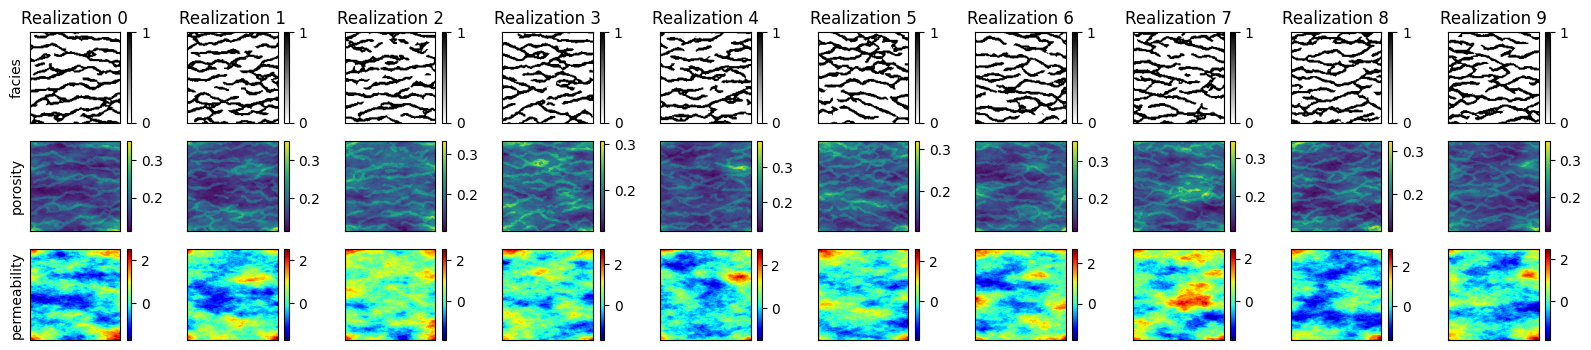

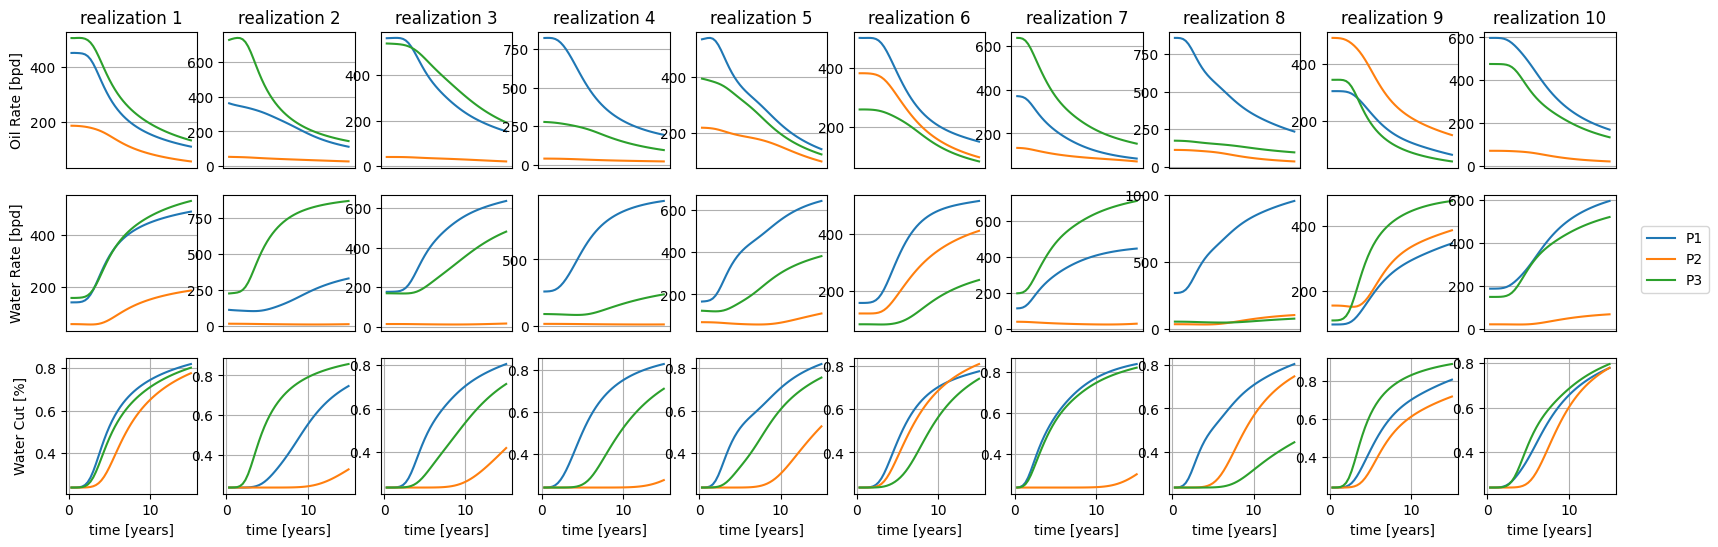

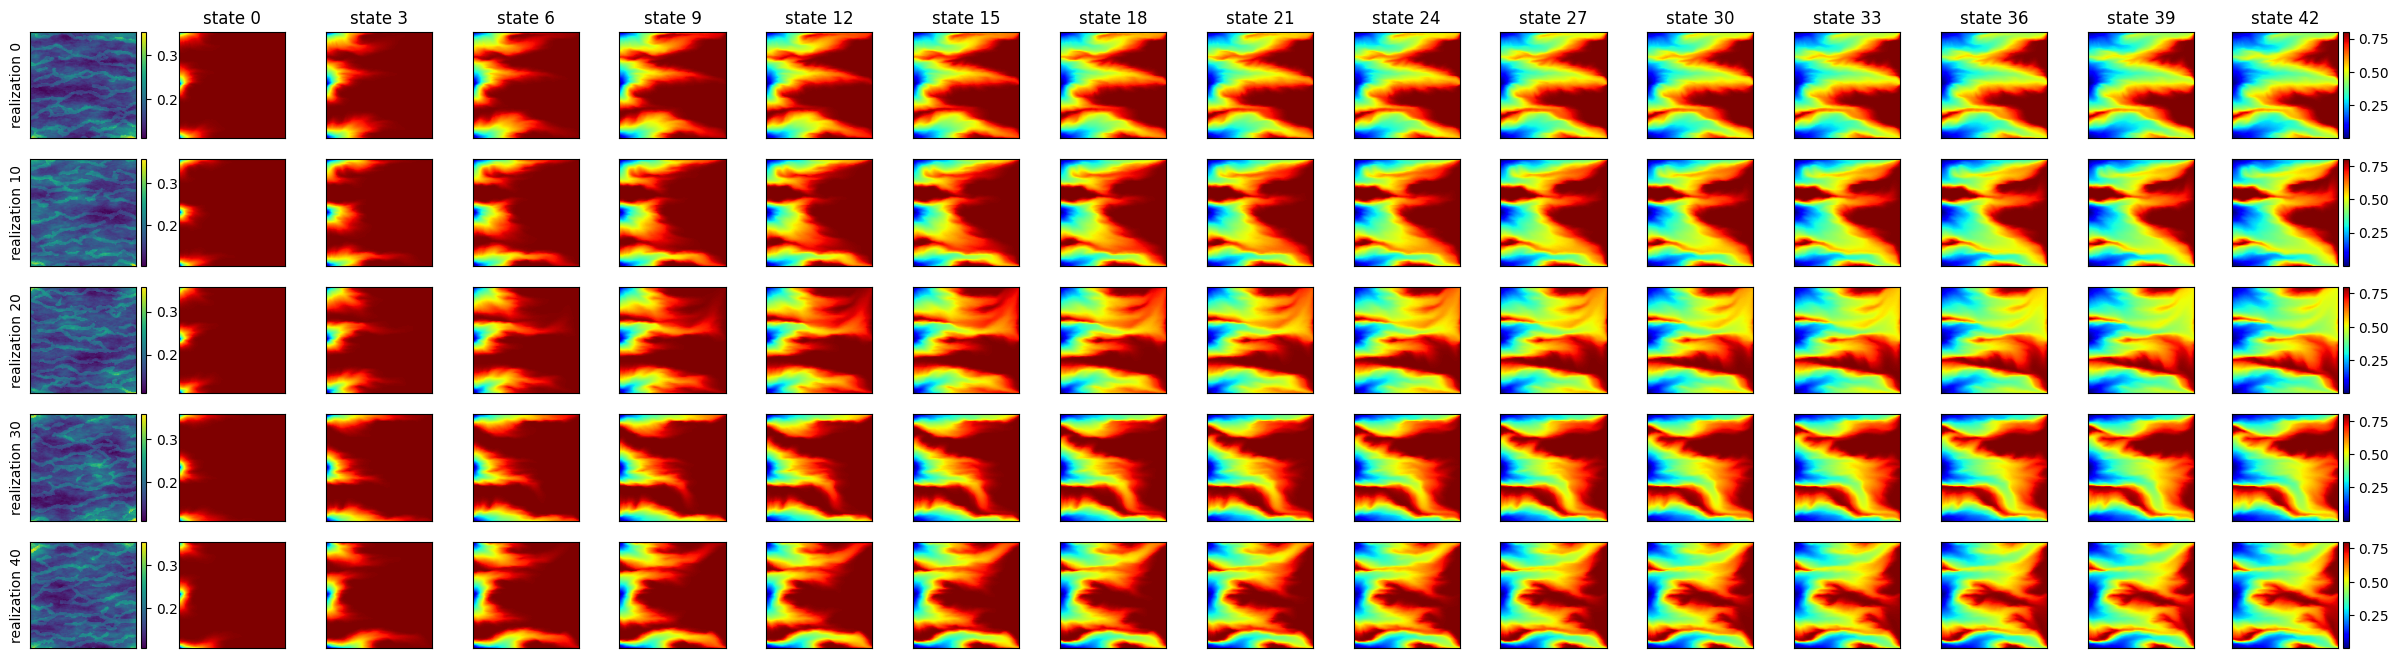

In [4]:
plot_static(poro, perm, channels)
plot_data(timestamps, well_opr, well_wpr, well_wcut)
plot_dynamic(poro, saturation, multiplier=10, cmaps=['viridis','jet'])
# make_dynamic_animation(poro, [pressure,saturation])

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [6]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data = split_xyw(poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (1000, 45, 128, 128, 2) | w shape: (1000, 45, 3, 3) 
y shape: (1000, 128, 128, 3) | t shape: (45,)


In [7]:
# Perform train-test split
X_train, X_test, y_train, y_test, w_train, w_test, randx, randy = my_train_test_split(X_data, y_data, w_data, nobs=30)

X_train shape: (700, 45, 30, 2)   | X_test shape: (300, 45, 30, 2)
w_train shape: (700, 45, 3, 3)    | w_test shape: (300, 45, 3, 3)
y_train shape: (700, 128, 128, 3) | y_test shape: (300, 128, 128, 3)


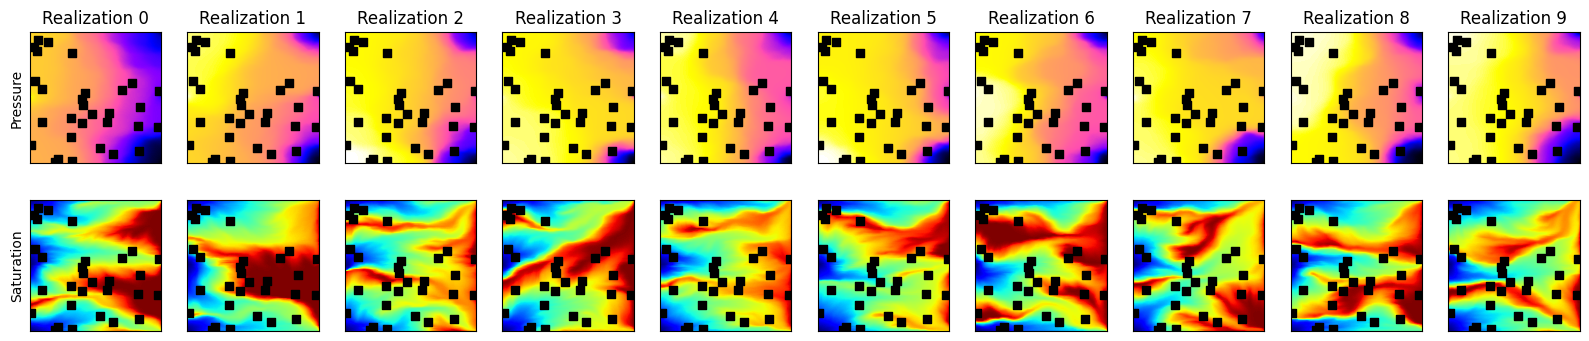

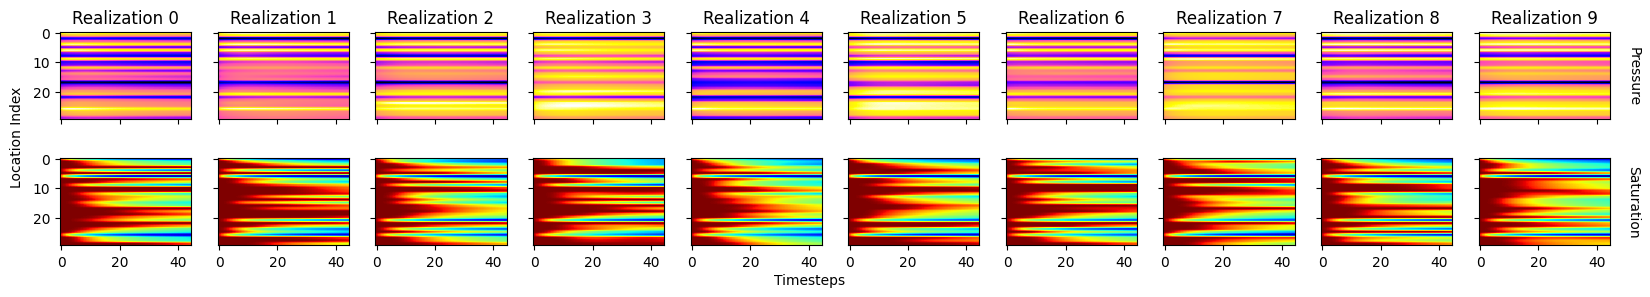

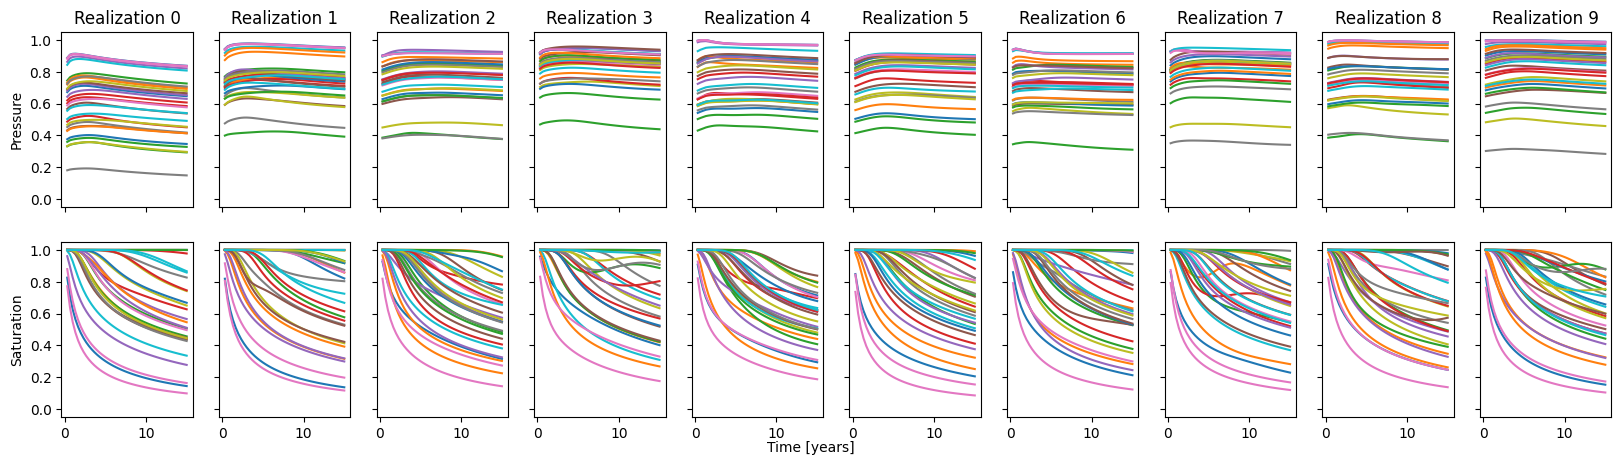

In [8]:
# Visualize X-samples
plot_X_img_observation(X_data, randx, randy)
plot_X_observation(X_train)
plot_X_line_observation(X_train, timestamps)

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

2024-03-15 12:37:19.256969: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-03-15 12:37:19.781875: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f16681e2fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 12:37:19.781912: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-15 12:37:19.793148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-15 12:37:19.817974: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710524239.889973    2735 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Parameters: 308,025 | Training time: 0.35 minutes


2024-03-15 12:37:44.528027: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


# Parameters: 40,238 | Training time: 2.98 minutes
# Parameters: 5,610,120 | Training time: 0.40 minutes


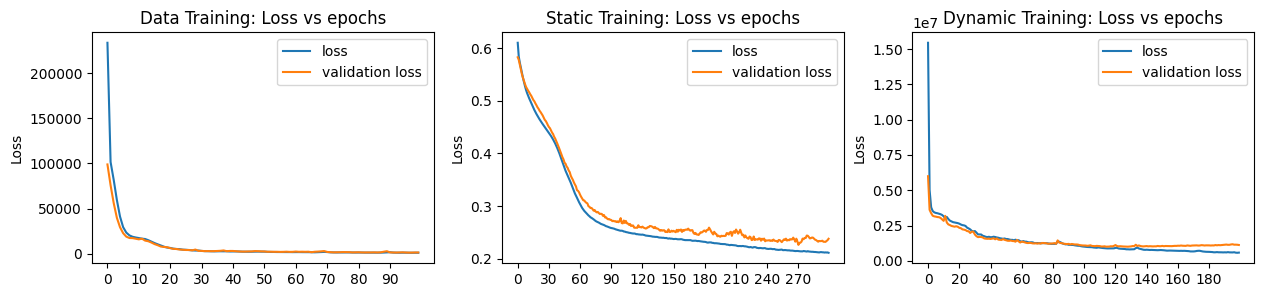

In [9]:
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
plot_loss_all(data_fit, static_fit, dynamic_fit)

10/10 [==============================] - 0s 3ms/step
Train MSE: 4.84e-04 | Test MSE: 4.84e-04
Image data must have shape at least (7x7) for ssim calculation


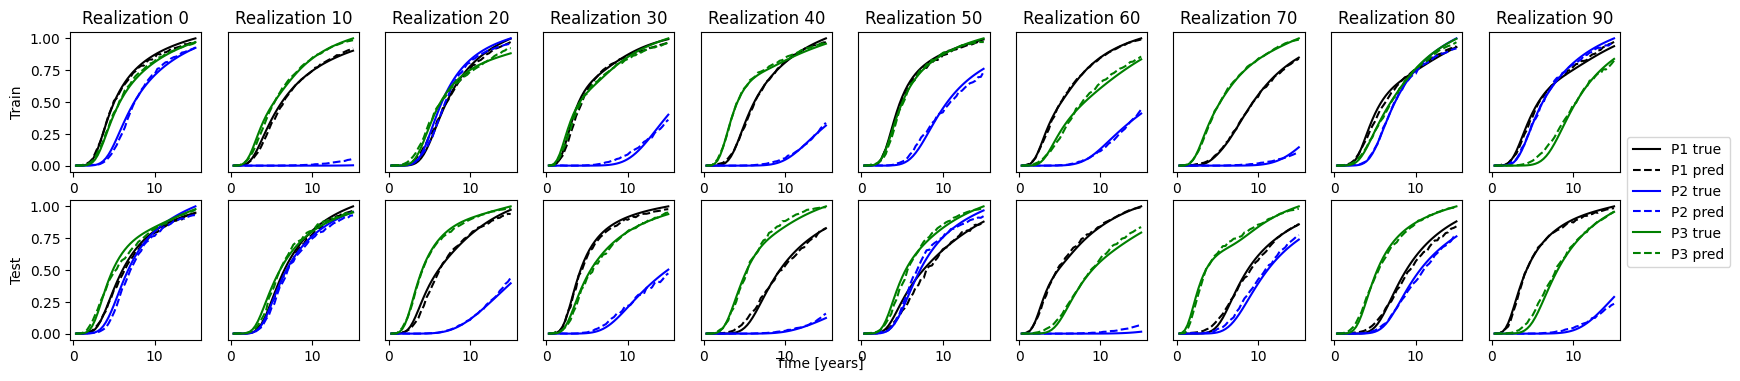

In [10]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_test, w_train_pred, w_test_pred, channel_select=2, multiplier=10)

10/10 [==============================] - 0s 14ms/step
Train MSE: 2.83e-02 | Test MSE: 2.83e-02
Train SSIM: 83.65 | Test SSIM: 83.22


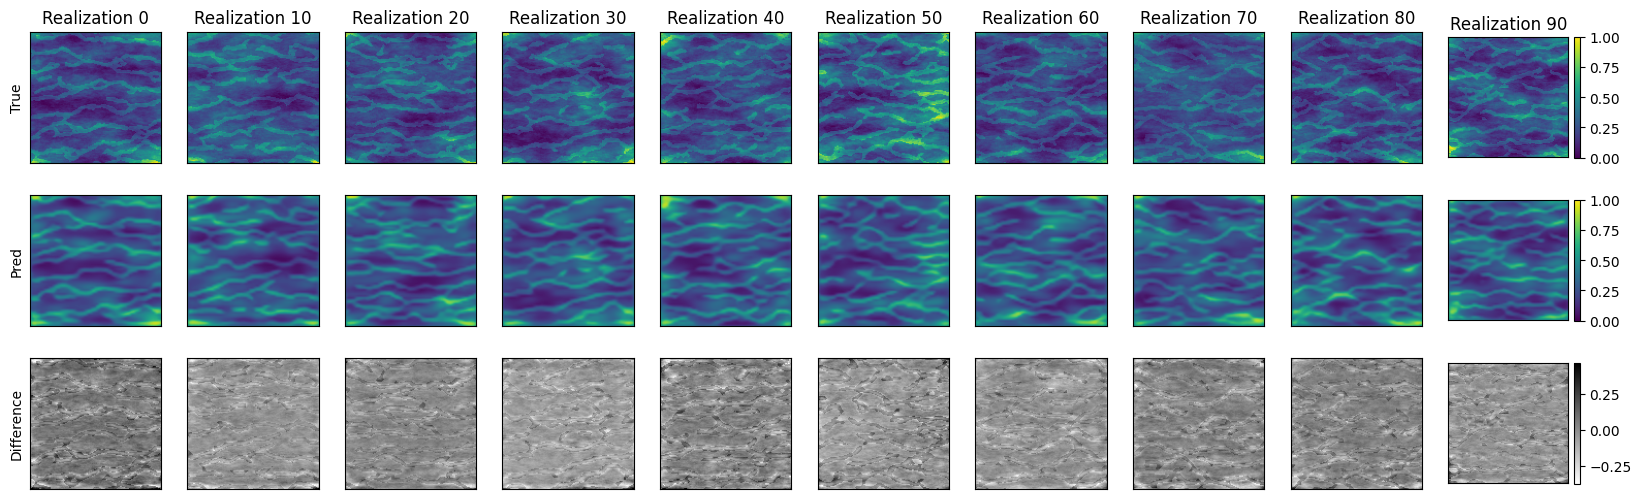

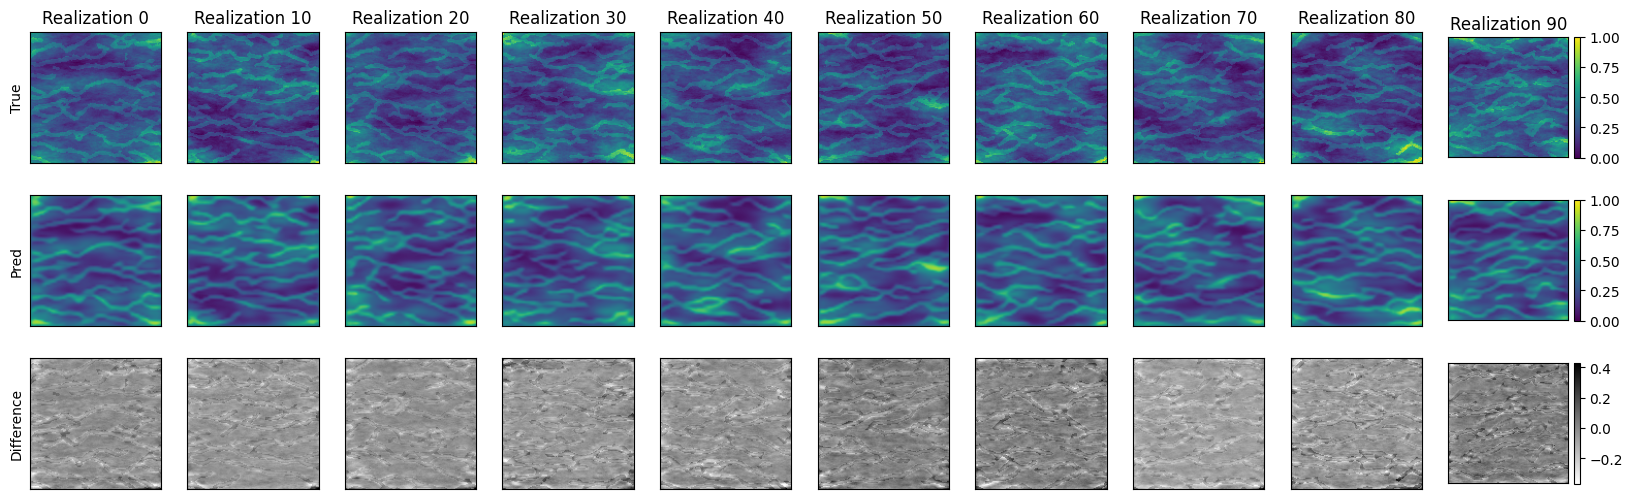

In [11]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results(y_train, y_train_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])
plot_static_results(y_test, y_test_pred, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

10/10 [==============================] - 0s 2ms/step
Train MSE: 2.40e-03 | Test MSE: 2.40e-03
Train SSIM: 95.56 | Test SSIM: 92.05


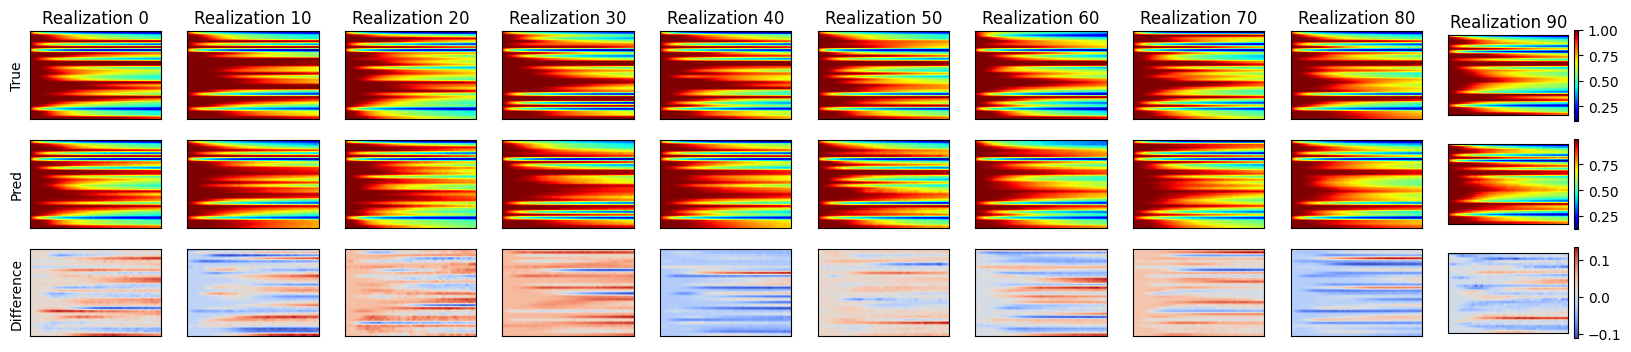

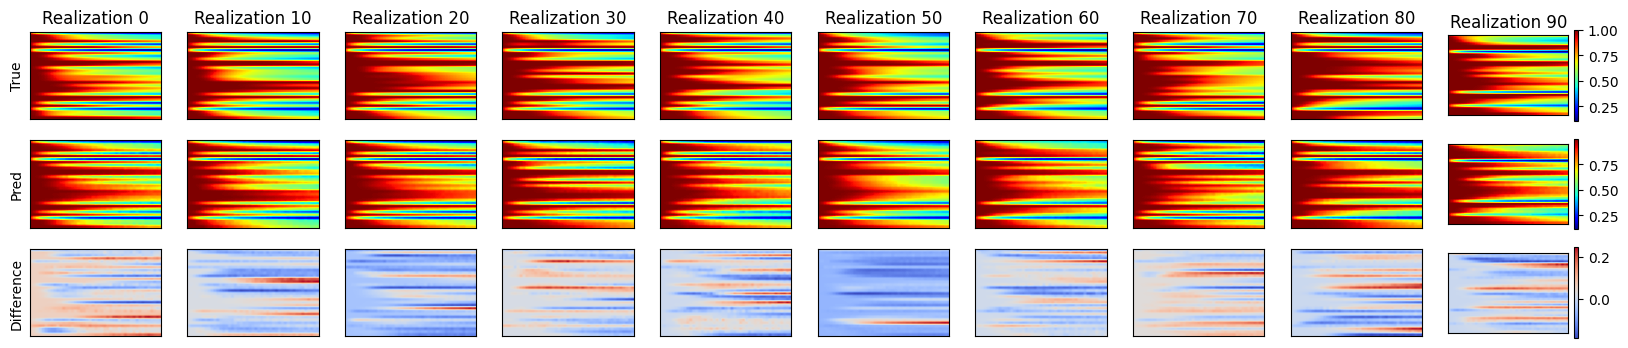

In [12]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results(X_train, X_train_pred, multiplier=10, channel_select=1)
plot_dynamic_results(X_test, X_test_pred, multiplier=10, channel_select=1)

***
# Build, Compile, Train, and Predict with Latent-Inversion Network

In [13]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (1000, 45, 30, 2) | w_full: (1000, 45, 3, 3) | y_full: (1000, 128, 128, 3)


# Parameters: 62,959,895 | Training time: 4.46 minutes


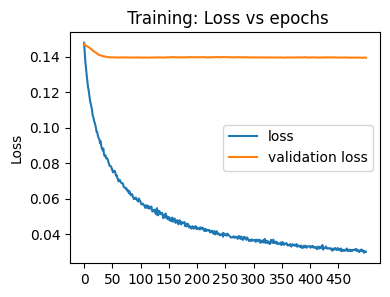

In [14]:
reg, reg_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(reg_fit, figsize=(4,3))

In [15]:
inv_train, inv_test = make_inv_prediction(reg, [X_train, X_test], [w_train, w_test], [y_train, y_test])

10/10 [==============================] - 0s 16ms/step
Train MSE: 2.36e-02 | Test MSE: 1.01e-01
Train SSIM: 80.47 | Test SSIM: 38.32


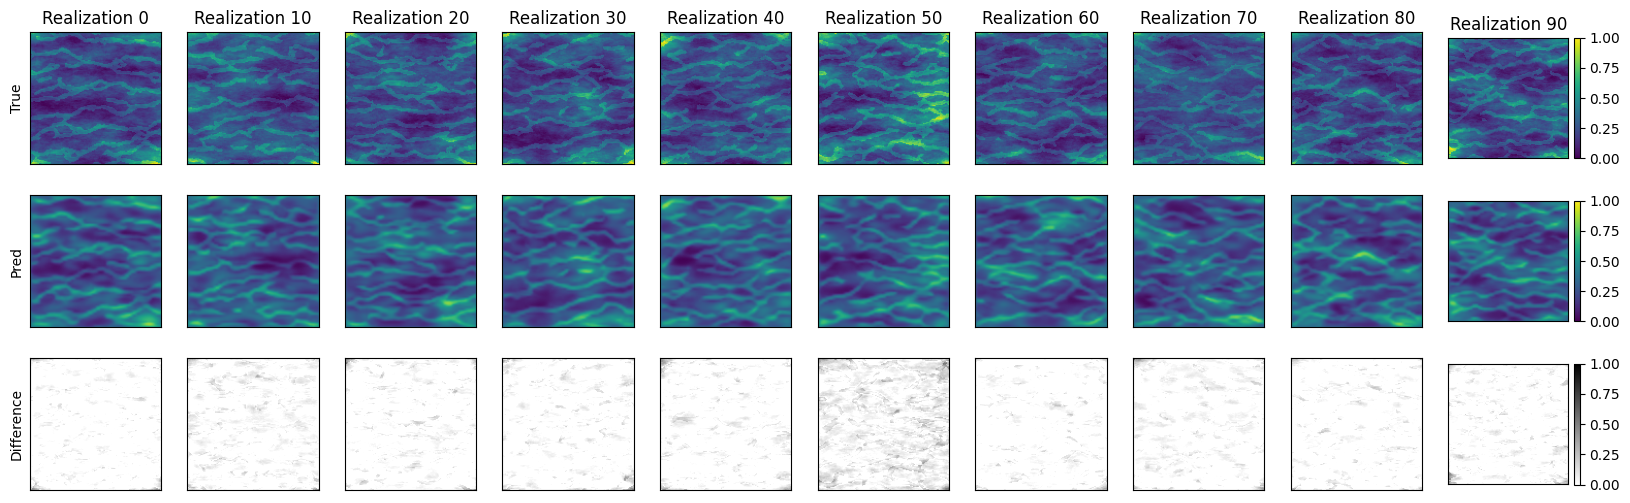

In [16]:
plot_inversion_result(y_train, inv_train, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

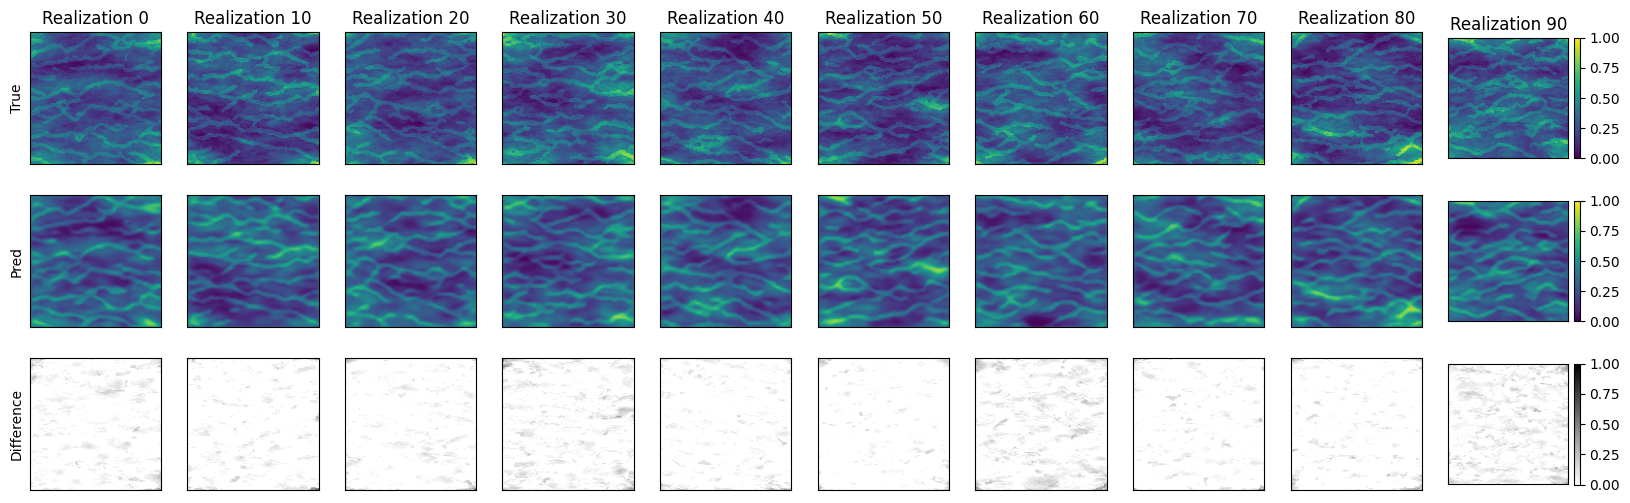

In [17]:
plot_inversion_result(y_test, inv_test, multiplier=10, channel_select=0, cmaps=['viridis','gray_r'])

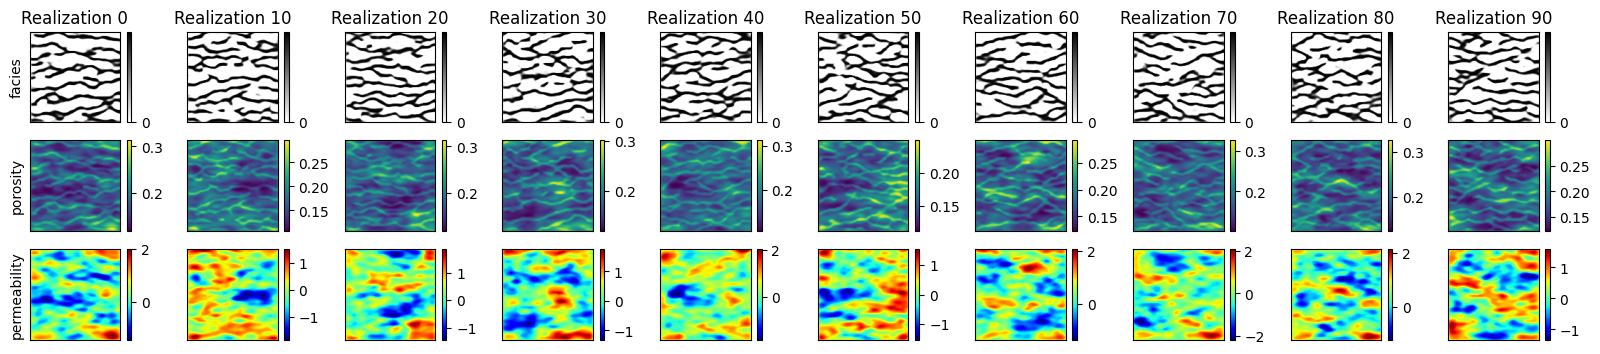

In [18]:
poro_hat, perm_hat, channels_hat = make_inv_backnorm([inv_train, inv_test], [poro, perm, channels])
plot_static(poro_hat, perm_hat, channels_hat, multiplier=10)

***
# Build, Compile, Train, and Predict with Latent-Forward Network

# Parameters: 5,081,144 | Training time: 3.77 minutes


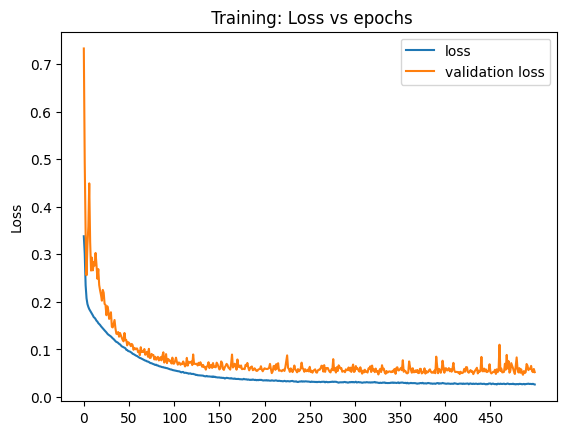

In [19]:
fwd, fwd_fit = make_fwd_regressor(X_full, w_full, y_full, dynamic_dec, data_dec, static_enc)
plot_loss(fwd_fit)

In [20]:
fwd_X, fwd_w = make_fwd_prediction(fwd, [X_train, X_test], [w_train, w_test], [y_train, y_test])

10/10 [==============================] - 0s 14ms/step
X - MSE: Train 1.33e-02 | Test: 1.90e-02
w - MSE: Train 5.88e-03 | Test: 2.00e-02


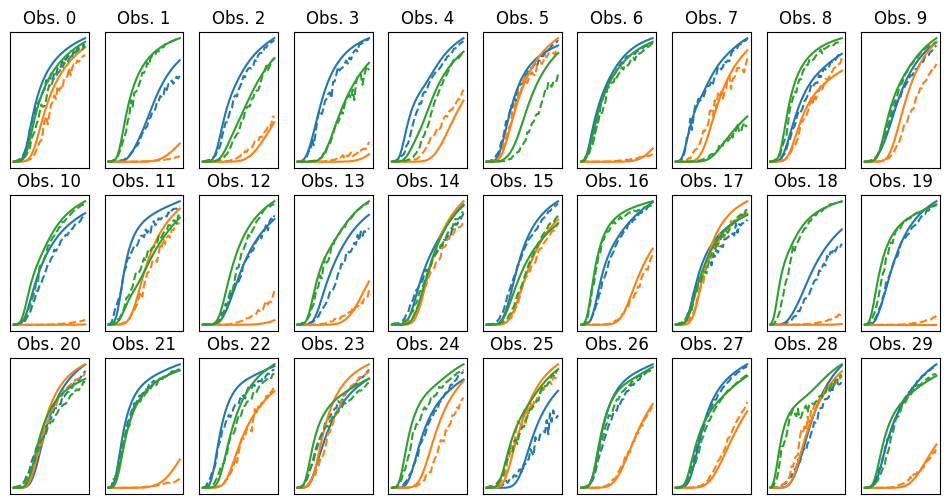

In [21]:
nrows = 3
ncols = 10
channel_select = 2
colors = ['tab:blue','tab:orange','tab:green']

plt.figure(figsize=(12,6))
k = 0
for i in range(nrows):
    for j in range(ncols):
        plt.subplot(nrows,ncols,k+1)
        plt.grid(True, which='both')
        plt.title('Obs. {}'.format(k))
        for t in range(3):
            plt.plot(w_train[k,:,t,channel_select], color=colors[t], label='W#{}'.format(t))
            plt.plot(fwd_w['train'][k,:,t,channel_select], linestyle='--', color=colors[t])
        plt.xticks([]); plt.yticks([])
        k += 1

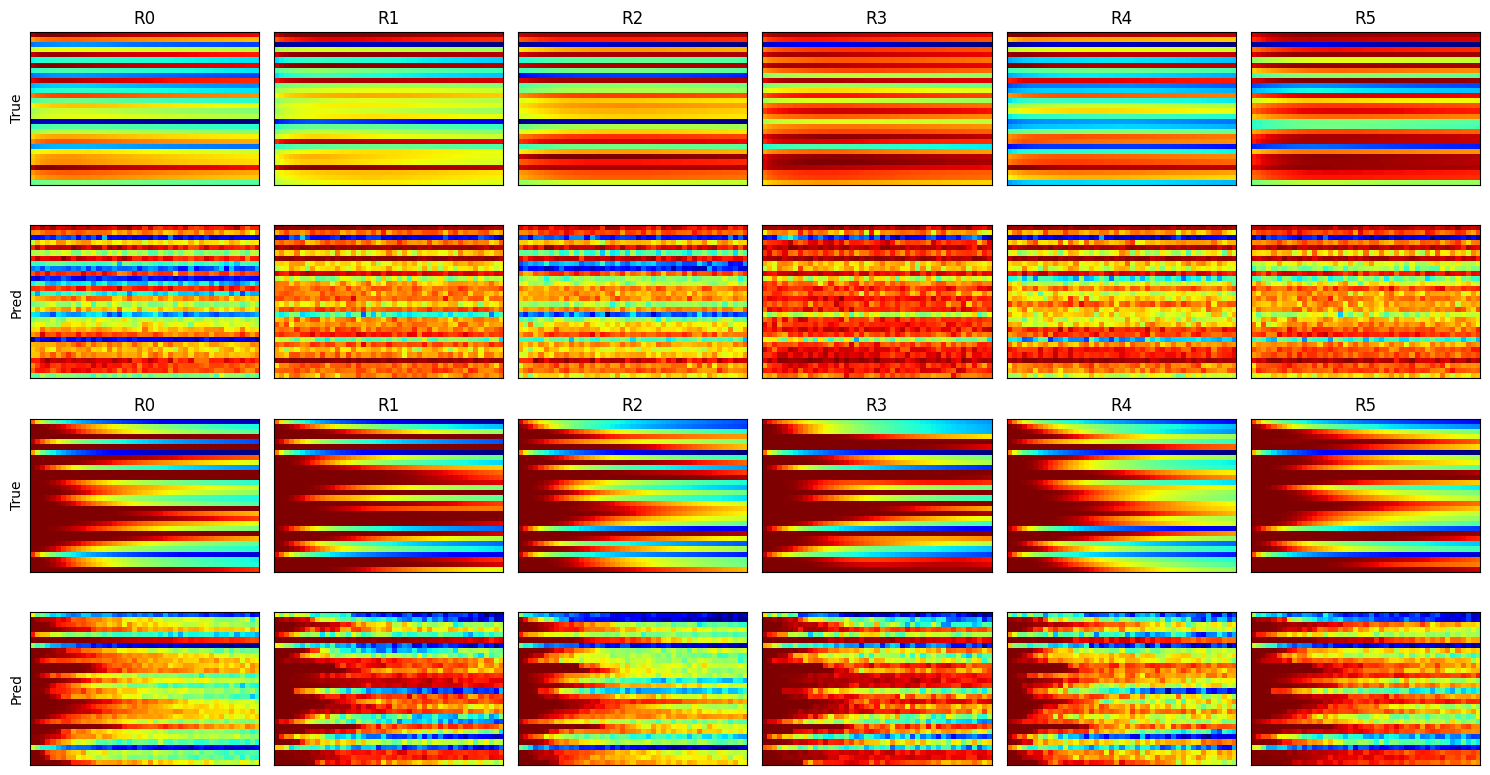

In [22]:
nrows = 4
ncols = 6

fig, axs = plt.subplots(nrows, ncols, figsize=(15,8))

for j in range(ncols):
    axs[0,j].imshow(X_train[j,:,:,0].T, cmap='jet')
    axs[0,0].set_ylabel('True')
    axs[1,j].imshow(fwd_X['train'][j,:,:,0].T, cmap='jet')
    axs[1,0].set_ylabel('Pred')
    axs[0,j].set_title('R{}'.format(j))

    axs[2,j].imshow(X_train[j,:,:,1].T, cmap='jet')
    axs[2,0].set_ylabel('True')
    axs[3,j].imshow(fwd_X['train'][j,:,:,1].T, cmap='jet')
    axs[3,0].set_ylabel('Pred')
    axs[2,j].set_title('R{}'.format(j))

    for i in range(nrows):
        axs[i,j].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

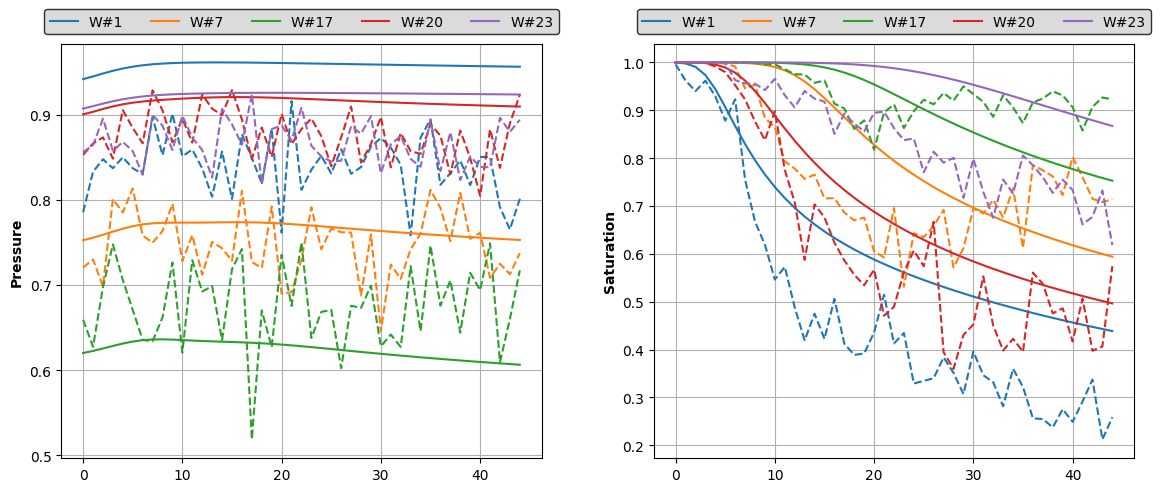

In [23]:
nwells = X_train.shape[2]
colors = ['tab:blue','tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:brown']
labels = ['Pressure','Saturation']
realization_select = 10
nw = 5
idx = np.sort(np.random.choice(range(nwells), size=nw, replace=False))

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharex=True)
for j in range(2):
    for i in range(nw):
        axs[j].plot(X_train[realization_select,:,idx[i],j], color=colors[i], label='W#{}'.format(idx[i]))
        axs[j].plot(fwd_X['train'][realization_select,:,idx[i],j], linestyle='--', color=colors[i])
        axs[j].legend(loc='upper center', ncols=nw, facecolor='lightgrey', edgecolor='k', bbox_to_anchor=(0.5,1.1))
    axs[j].grid(True, which='both')
    axs[j].set_ylabel(labels[j], weight='bold')
plt.tight_layout()
plt.show()

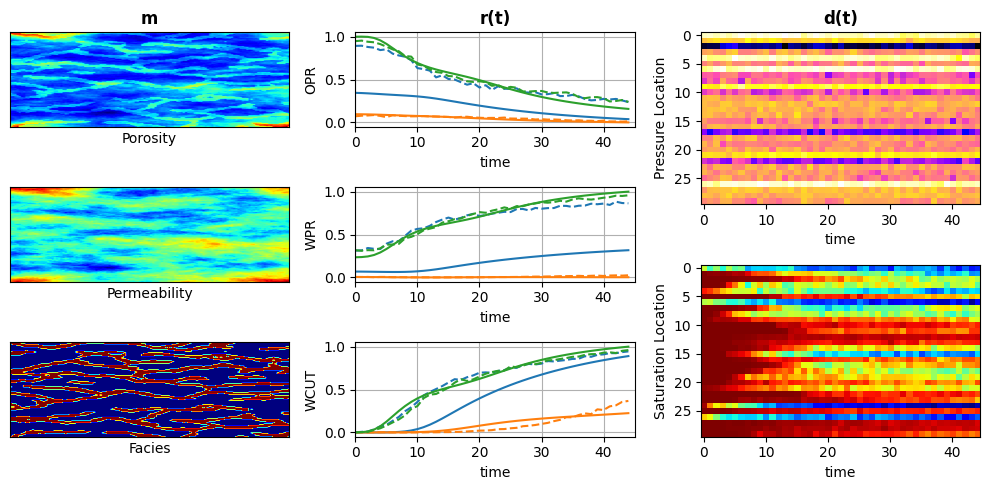

In [34]:
fig = plt.figure(figsize=(10,5))
gs = GridSpec(6, 3, figure=fig)

ax11 = fig.add_subplot(gs[0:2, 0])
ax12 = fig.add_subplot(gs[2:4, 0])
ax13 = fig.add_subplot(gs[4:6, 0])
ax1 = [ax11, ax12, ax13]

ax21 = fig.add_subplot(gs[0:2, 1])
ax22 = fig.add_subplot(gs[2:4, 1])
ax23 = fig.add_subplot(gs[4:6, 1])
ax2 = [ax21, ax22, ax23]

ax31 = fig.add_subplot(gs[0:3, 2])
ax32 = fig.add_subplot(gs[3:6, 2])
ax3 = [ax31, ax32]

realization = 41
colors = ['tab:blue','tab:orange','tab:green']
x_cmaps = ['gnuplot2','jet']
x_labels = ['Pressure','Saturation']
w_labels = ['OPR','WPR','WCUT']
y_labels = ['Porosity','Permeability','Facies']

for i in range(3):
    ax1[i].imshow(y_train[realization,:,:,i], cmap='jet', aspect='auto')
    ax1[i].set(xticks=[], yticks=[], xlabel=y_labels[i])
ax11.set_title('m', weight='bold')

for i in range(3):
    for j in range(3):
        ax2[j].plot(w_train[realization,:,i,j], color=colors[i])
        ax2[j].plot(fwd_w['train'][k,:,i,j], color=colors[i], linestyle='--')
    ax2[i].grid(True, which='both')
    ax2[i].set(ylabel=w_labels[i], xlabel='time')
ax21.set_title('r(t)', weight='bold')

for i in range(2):
    ax3[i].imshow(fwd_X['train'][realization,:,:,i].T, cmap=x_cmaps[i], aspect='auto')
    ax3[i].set(ylabel=x_labels[i]+' Location', xlabel='time')
ax31.set_title('d(t)', weight='bold')

for ax in ax2:
    ax.set(xlim=(0,45))

plt.tight_layout()
plt.show()

***
# END